# Annalyse non supervisée

## Chargement des features

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

df_features = pd.read_parquet("../data/brain_features_resnet50.parquet")
df_features.head()

,filepath,has_label,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,label_num
0,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.011641,0.014855,0.309468,0.112984,0.092031,0.000000,0.443308,...,0.050269,0.062702,0.118318,0.034898,0.199230,1.656034,0.041210,0.073140,0.369943,1
1,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.047576,0.045124,0.004747,0.000000,0.000000,0.000000,0.003254,...,0.000000,0.123328,0.000000,0.027098,0.290650,0.242351,0.000000,0.000000,0.000000,1
2,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.023101,0.067208,0.135242,0.000000,0.000000,0.000375,0.203493,...,0.007180,0.127119,0.000000,0.102672,0.980460,0.702292,0.000000,0.000000,0.000000,1
3,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.003039,0.192276,0.042327,0.000000,0.004168,0.000000,1.024806,...,0.069563,0.017233,0.060294,0.020966,0.134899,0.357556,0.000686,0.011123,0.063624,1
4,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.151541,0.046058,0.109404,0.000000,0.026315,0.008330,0.357026,...,0.091114,0.005454,0.010853,0.042849,0.361198,0.324573,0.012139,0.001569,0.194653,1


### Récupération des colonnes de features

In [5]:
feature_cols = [c for c in df_features.columns if c.startswith("f_")]
X = df_features[feature_cols].values  # shape (1500, 2048)

print(X.shape)

(1506, 2048)


### Test de la variance avant PCA

Variance moyenne brute : 0.038779248
Variance totale brute  : 79.4199


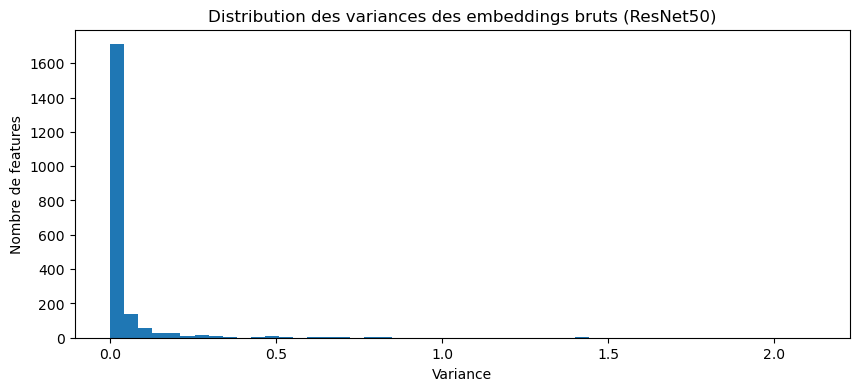

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Variance brute des embeddings ResNet50
var_raw = X.var(axis=0)

print("Variance moyenne brute :", var_raw.mean())
print("Variance totale brute  :", var_raw.sum())

plt.figure(figsize=(10,4))
plt.hist(var_raw, bins=50)
plt.title("Distribution des variances des embeddings bruts (ResNet50)")
plt.xlabel("Variance")
plt.ylabel("Nombre de features")
plt.show()

## PCA

In [9]:
# Pas de standardisation : on travaille directement sur les embeddings bruts
X_raw = X.copy()

# PCA pour réduire à 50 dims
pca_50 = PCA(n_components=50, random_state=42)
X_pca50 = pca_50.fit_transform(X_raw)

print("Variance expliquée (50 comps) :", pca_50.explained_variance_ratio_.sum())

Variance expliquée (50 comps) : 0.7608904


Variance moyenne PCA(50) : 0.015217808
Variance totale PCA(50) : 0.7608904


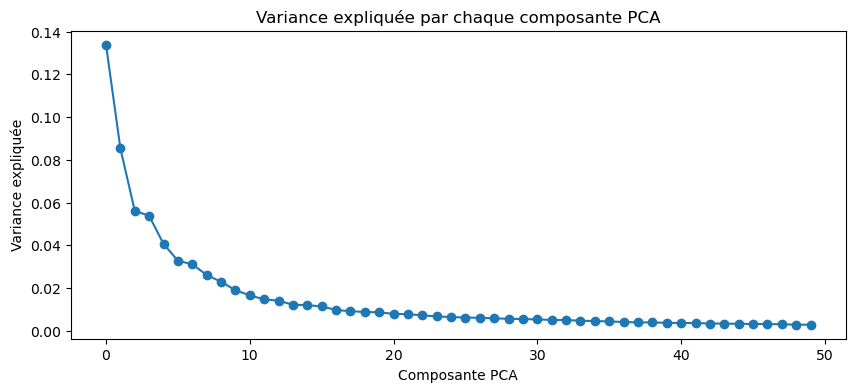

In [10]:
# Variance expliquée par composante
var_pca = pca_50.explained_variance_ratio_

print("Variance moyenne PCA(50) :", var_pca.mean())
print("Variance totale PCA(50) :", var_pca.sum())

plt.figure(figsize=(10,4))
plt.plot(var_pca, marker='o')
plt.title("Variance expliquée par chaque composante PCA")
plt.xlabel("Composante PCA")
plt.ylabel("Variance expliquée")
plt.show()

La PCA à 50 composantes conserve environ 76%

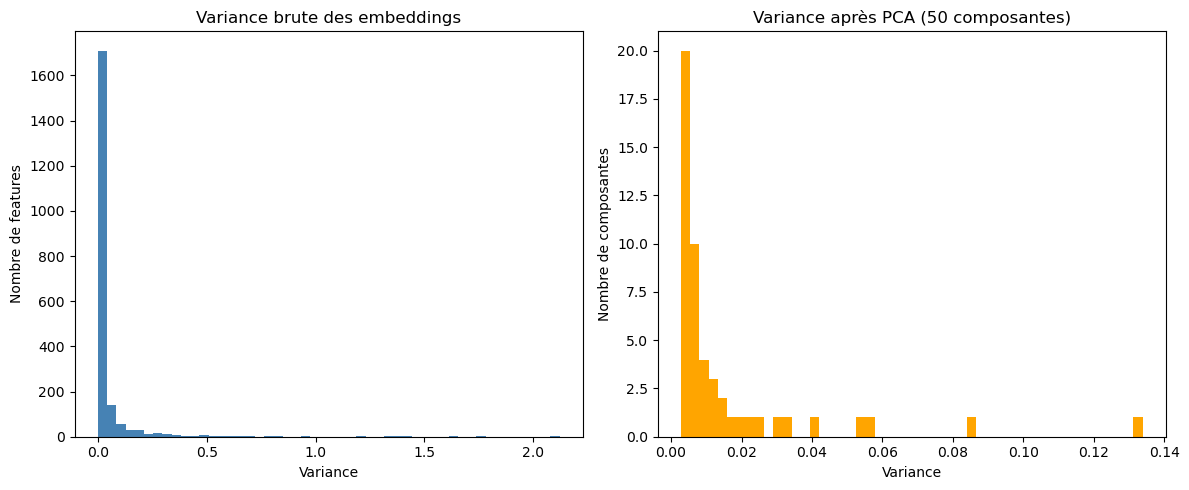

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(var_raw, bins=50, color="steelblue")
plt.title("Variance brute des embeddings")
plt.xlabel("Variance")
plt.ylabel("Nombre de features")

plt.subplot(1,2,2)
plt.hist(var_pca, bins=50, color="orange")
plt.title("Variance après PCA (50 composantes)")
plt.xlabel("Variance")
plt.ylabel("Nombre de composantes")

plt.tight_layout()
plt.show()

## KMeans (clustering principal)

Uniquement dans un but d'expérimentation, car il y 2 groupes définis.

### Essai de plusieurs valeurs de k avec PCA

C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

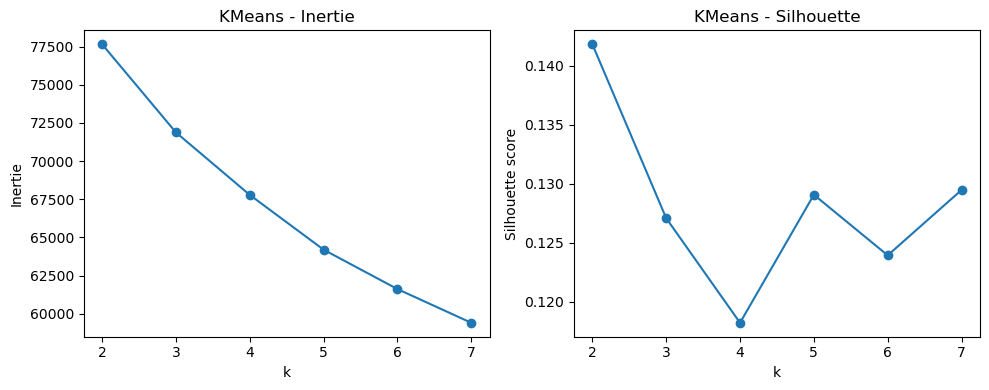

In [16]:
inertias = []
sil_scores = []
K_RANGE = range(2, 8)

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_pca50)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_pca50, labels_k))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_RANGE), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertie")
plt.title("KMeans - Inertie")

plt.subplot(1,2,2)
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("KMeans - Silhouette")
plt.tight_layout()
plt.show()

### Fit final avec k choisi

In [18]:
K = 2
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca50)

df_features["cluster_kmeans"] = clusters
df_features["cluster_kmeans"].value_counts()

C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


cluster_kmeans
1    831
0    675
Name: count, dtype: int64

## Visualisation 2D

### PCA à 2 composants pour les scatters plots

In [21]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_raw)

df_features["pc1"] = X_pca2[:,0]
df_features["pc2"] = X_pca2[:,1]

### Scatter coloré par cluster

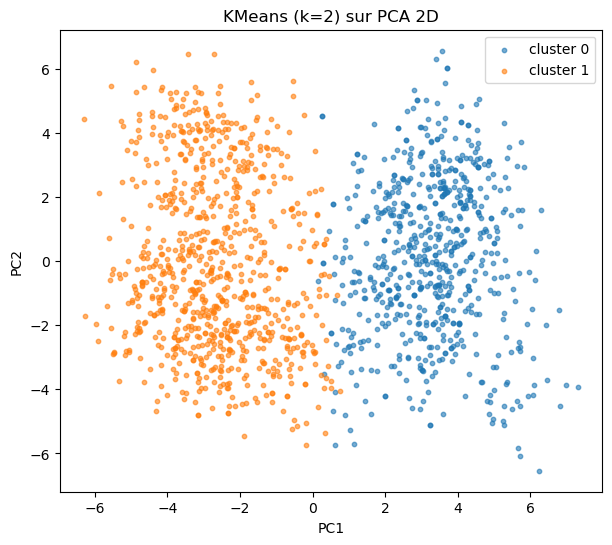

In [23]:
plt.figure(figsize=(7,6))
for c in sorted(df_features["cluster_kmeans"].unique()):
    subset = df_features[df_features["cluster_kmeans"] == c]
    plt.scatter(subset["pc1"], subset["pc2"], s=10, alpha=0.6, label=f"cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans (k=2) sur PCA 2D")
plt.legend()
plt.show()

### Scatter coloré par label (images annotées)

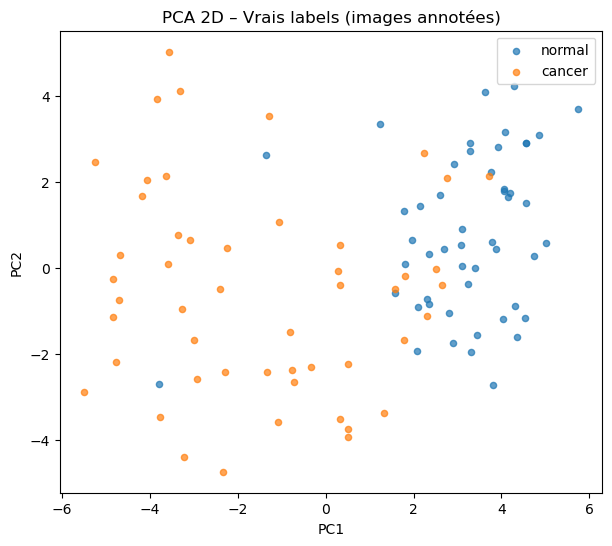

In [25]:
labeled = df_features[df_features["label"].notna()]

plt.figure(figsize=(7,6))
for lab in ["normal", "cancer"]:
    subset = labeled[labeled["label"] == lab]
    plt.scatter(subset["pc1"], subset["pc2"], s=20, alpha=0.7, label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D – Vrais labels (images annotées)")
plt.legend()
plt.show()

## Evaluation des clusters avec les labels connus

Fonction de réalignement des matrices de confusion

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix

def diagonalize_confusion_matrix(y_true, y_cluster):
    """
    Réaligne les labels de clusters (k=2) afin de maximiser la diagonale
    de la matrice de confusion.

    Parameters
    ----------
    y_true : array-like
        Labels réels (ex: 0=normal, 1=cancer)
    y_cluster : array-like
        Labels de clusters prédits (ex: 0, 1)

    Returns
    -------
    y_cluster_aligned : np.ndarray
        Labels de clusters réalignés
    cm_final : np.ndarray
        Matrice de confusion diagonalisée
    flipped : bool
        Indique si les labels ont été inversés
    """
    cm = confusion_matrix(y_true, y_cluster)
    cm_flipped = confusion_matrix(y_true, 1 - y_cluster)

    if np.trace(cm_flipped) > np.trace(cm):
        return 1 - y_cluster, cm_flipped, True
    else:
        return y_cluster, cm, False

Evaluation du KMeans sur sous-ensemble

In [30]:
labeled = df_features[df_features["label"].notna()].copy()

y_true = labeled["label"].map({"normal": 0, "cancer": 1}).values
y_cluster = labeled["cluster_kmeans"].values

print("ARI :", adjusted_rand_score(y_true, y_cluster))
print("NMI :", normalized_mutual_info_score(y_true, y_cluster))
print("Silhouette (global) :", silhouette_score(X_pca50, df_features["cluster_kmeans"]))

ARI : 0.48505024049347056
NMI : 0.43798897250861957
Silhouette (global) : 0.14184457


Matrice de confusion

In [32]:
y_cluster_kmean_aligned,cm,flipped = diagonalize_confusion_matrix(y_true, y_cluster)
flipped

False

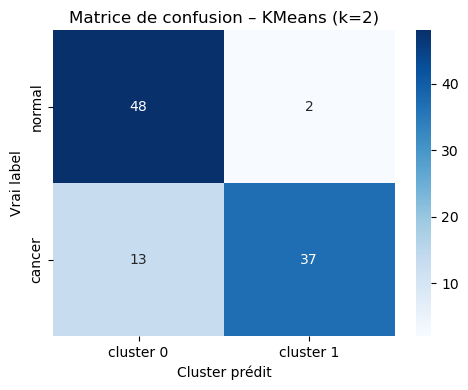

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["cluster 0", "cluster 1"],
    yticklabels=["normal", "cancer"]
)

plt.xlabel("Cluster prédit")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion – KMeans (k=2)")
plt.tight_layout()
plt.show()


### Conclusion

La matrice de confusion montre que les clusters obtenus par KMeans correspondent partiellement aux classes médicales réelles.
Chaque cluster est dominé par une classe (normal ou cancer), mais un chevauchement subsiste.
Ce résultat confirme que le clustering permet de générer des labels faibles exploitables, mais bruités.

## Test d'un autres modèle de clustering

### Fit du GMM sur les features utilisées pour le clustering

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import numpy as np

# GMM sur PCA(50)
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
gmm_clusters = gmm.fit_predict(X_pca50)

df_features["cluster_gmm"] = gmm_clusters

df_features["cluster_gmm"].value_counts()


C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


cluster_gmm
0    860
1    646
Name: count, dtype: int64

In [38]:
# Évaluation du GMM sur le sous-ensemble annoté
labeled = df_features[df_features["has_label"]].copy()

y_true = labeled["label"].map({"normal": 0, "cancer": 1}).values
y_cluster_gmm = labeled["cluster_gmm"].values

y_cluster_gmm_aligned,cm_gmm,flipped_gmm = diagonalize_confusion_matrix(y_true, y_cluster_gmm)
flipped_gmm

True

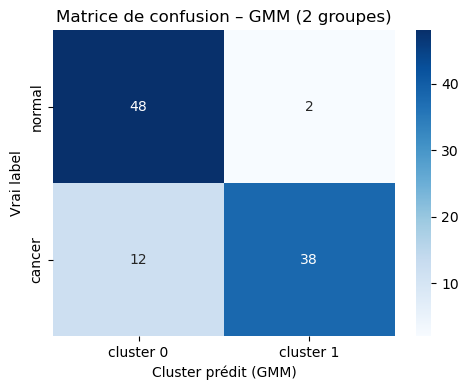

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_gmm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["cluster 0", "cluster 1"],
    yticklabels=["normal", "cancer"]
)

plt.xlabel("Cluster prédit (GMM)")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion – GMM (2 groupes)")
plt.tight_layout()
plt.show()

### Conclusion

La matrice de confusion du GMM montre une séparation comparable à celle obtenue avec KMeans.
Chaque composante gaussienne est dominée par une classe (normal ou cancer), mais un chevauchement subsiste.

### Evaluation avec les labels connus (ARI/NMI)

In [42]:
labeled = df_features[df_features["has_label"]].copy()
y_true = labeled["label"].map({"normal": 0, "cancer": 1}).values
y_cluster_gmm = labeled["cluster_gmm"].values

ari_gmm = adjusted_rand_score(y_true, y_cluster_gmm)
nmi_gmm = normalized_mutual_info_score(y_true, y_cluster_gmm)
sil_gmm = silhouette_score(X_pca50, df_features["cluster_gmm"])

print("GMM (2 groupes) sur PCA(50)")
print("ARI :", ari_gmm)
print("NMI :", nmi_gmm)
print("Silhouette :", sil_gmm)

# print("Matrice de confusion (labels vrais vs clusters GMM):")
# print(diagonalize_confusion_matrix(y_true, y_cluster_gmm))

GMM (2 groupes) sur PCA(50)
ARI : 0.5136842105263157
NMI : 0.458950479523655
Silhouette : 0.14057504


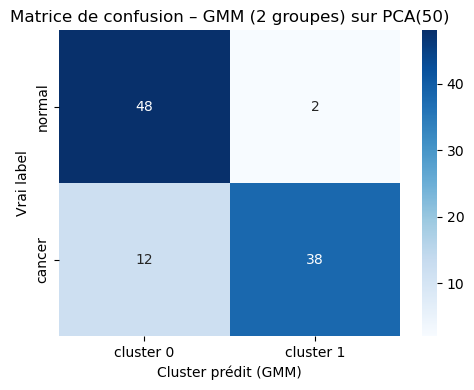

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_cluster_gmm_aligned,cm_gmm,flipped_gmm = diagonalize_confusion_matrix(y_true, y_cluster_gmm)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_gmm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["cluster 0", "cluster 1"],
    yticklabels=["normal", "cancer"]
)

plt.xlabel("Cluster prédit (GMM)")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion – GMM (2 groupes) sur PCA(50)")
plt.tight_layout()
plt.show()

Le GMM à deux composantes permet d'obtenir une correspondance légèrement meilleure avec les labels réels que KMeans, comme en témoignent les scores ARI et NMI plus élevés.
Chaque composante gaussienne est dominée par une classe (normal ou cancer), bien que les clusters restent partiellement superposés.
Ce résultat est cohérent avec la complexité du problème et confirme l'intérêt du GMM pour générer des labels faibles plus exploitables.

## Construction du jeu de données faiblement labellisé

L'objectif final de cette partie est de créer un ensemble d’images **faiblement labellisées** à partir du clustering non supervisé.  
Cet ensemble sera utilisé dans l’étape suivante (apprentissage semi-supervisé), conformément aux consignes du projet.

1. Nous disposons uniquement de **100 images annotées** (normal / cancer).
2. Nous avons appliqué un clustering **K-Means (k = 2)** sur les embeddings extraits par ResNet50.
3. En utilisant les **images annotées**, nous pouvons déterminer pour chaque cluster le label dominant (via la matrice de confusion).
4. Nous utilisons cette correspondance pour attribuer un **pseudo-label** aux images non annotées.

Ce processus produit un dataset dit **faiblement labellisé**, car les labels proviennent d’un algorithme non supervisé et sont donc potentiellement bruités.

Selon les consignes du projet, ce dataset doit être **conservé séparément** du dataset fortement labellisé.

### Détermination du mapping cluster > label

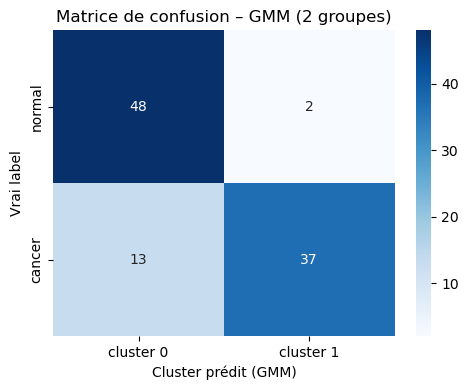

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Données annotées uniquement
labeled = df_features[df_features["has_label"]].copy()
y_true = labeled["label"].map({"normal": 0, "cancer": 1}).values
y_cluster = labeled["cluster_kmeans"].values

# Matrice de confusion cluster vs vrais labels
y_cluster_aligned,cm,flipped = diagonalize_confusion_matrix(y_true, y_cluster)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["cluster 0", "cluster 1"],
    yticklabels=["normal", "cancer"]
)

plt.xlabel("Cluster prédit (GMM)")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion – GMM (2 groupes)")
plt.tight_layout()
plt.show()


In [50]:
cluster_to_label = {}
for cluster in [0, 1]:
    # colonne = distribution des labels réels pour un cluster donné
    majority_label = np.argmax(cm[:, cluster])
    cluster_to_label[cluster] = majority_label

cluster_to_label


{0: 0, 1: 1}

### Synthèse – KMeans vs GMM

Les deux méthodes de clustering produisent des regroupements cohérents avec les classes médicales réelles, confirmant la qualité des embeddings extraits par ResNet50.

Le GMM obtient des performances légèrement supérieures en termes de correspondance avec les labels connus, ce qui justifie son utilisation préférentielle pour la génération de labels faibles dans la suite du projet.


### Construction du jeu faiblement labellisé

In [52]:
# Images non annotées
df_unlabeled = df_features[df_features["has_label"] == False].copy()

# Ajout du pseudo-label numérique
df_unlabeled["weak_label_num"] = df_unlabeled["cluster_kmeans"].map(cluster_to_label)

# Ajout du pseudo-label texte
inv_map = {0: "normal", 1: "cancer"}
df_unlabeled["weak_label"] = df_unlabeled["weak_label_num"].map(inv_map)

df_unlabeled.head()

,filepath,has_label,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_2045,f_2046,f_2047,label_num,cluster_kmeans,pc1,pc2,cluster_gmm,weak_label_num,weak_label
100,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.000000,0.032982,0.029727,0.005724,0.000000,0.001122,0.396253,...,0.000000,0.006705,0.105339,-1,1,-3.053053,-0.308151,0,1,cancer
101,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.007041,0.001747,0.021182,0.000000,0.019327,0.000000,0.207386,...,0.012702,0.080563,0.000000,-1,0,1.125995,-0.646369,1,0,normal
102,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.023832,0.007033,0.166738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.036756,0.000000,-1,0,4.326520,2.024978,1,0,normal
103,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.028333,0.000000,0.066101,0.000000,0.026202,0.000000,0.535859,...,0.027819,0.000000,0.162083,-1,0,0.904184,0.646855,1,0,normal
104,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.000000,0.203467,0.394194,0.000000,0.000000,0.024501,0.376836,...,0.000000,0.000000,0.051782,-1,1,-3.553420,-1.572462,0,1,cancer


### Sauvegarde du dataset faible

In [54]:
df_unlabeled[["filepath", "weak_label_num", "weak_label"]].to_parquet(
    "../data/brain_weak_labels_kmeans.parquet",
    index=False
)

### Résultat

Nous avons maintenant un dataset contenant toutes les images non annotées accompagnées de labels issus du clustering.  
Ce nouveau fichier (`brain_weak_labels_kmeans.parquet`) constitue notre **jeu faiblement labellisé**.

Il sera utilisé dans le prochain notebook pour entraîner un modèle CNN en mode **semi-supervisé**, selon le protocole demandé : 
1. entraînement sur le jeu faiblement labellisé,
2. puis entraînement sur le jeu fortement labellisé.
